# AirPassengers Dataset(not working)

In [12]:
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
import pandas as pd
import numpy as np

In [13]:
series = AirPassengersDataset().load()
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)> Size: 1kB
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
# Convert to average daily passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)> Size: 576B
array([[[ 3.612903 ]],

       [[ 4.214286 ]],

       [[ 4.2580647]],

       [[ 4.3      ]],

       [[ 3.903226 ]],

       [[ 4.5      ]],

       [[ 4.774194 ]],

       [[ 4.774194 ]],

       [[ 4.5333333]],

       [[ 3.8387096]],

...

       [[13.5161295]],

       [[15.366667 ]],

       [[15.225806 ]],

       [[17.833334 ]],

       [[20.064516 ]],

       [[19.548388 ]],

       [[16.933332 ]],

       [[14.870968 ]],

       [[13.       ]],

       [[13.935484 ]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [15]:
# Split into training and validation sets
train, val = series.split_after(pd.Timestamp("19571201"))

In [16]:
# Normalize the series
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [17]:
# Generate future covariates: year, month, and a linear trend
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="month", one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(
    times=series.time_index,
    values=np.arange(len(series)),
    columns=["linear_trend"]
))
covariates = covariates.astype(np.float32)

In [18]:
# Normalize covariates
scaler_covs = Scaler()
cov_train, _ = covariates.split_after(pd.Timestamp("19571201"))
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

## Train TFT Model

In [19]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

# Define quantiles for probabilistic forecasting
quantiles = [0.01, 0.1, 0.5, 0.9, 0.99]

# Initialize the model
model = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42
)

# Train the model
model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.2 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, random_state=42)

## Valuation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/kin/.pyenv/versions/3.9.10/lib/python3.9/site-packages/darts/metrics/metrics.py:2179: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/Users/kin/.pyenv/versions/3.9.10/lib/python3.9/site-packages/darts/metrics/metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


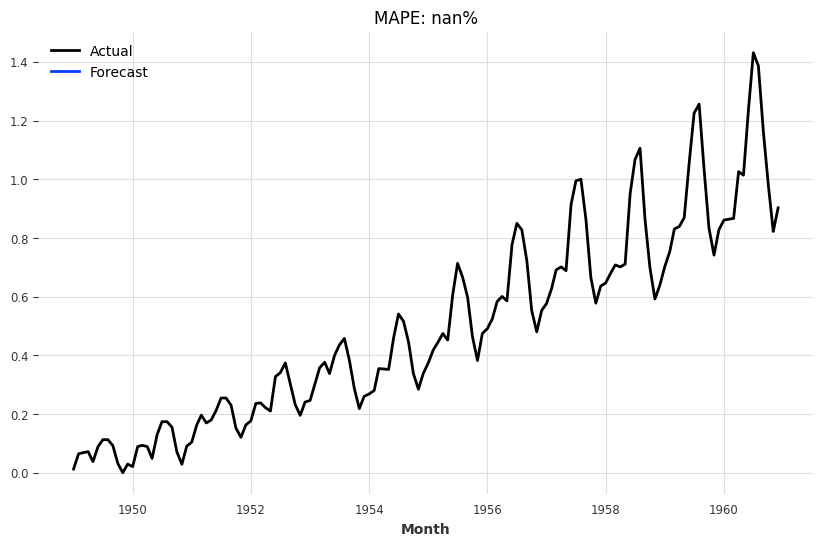

In [ ]:
from darts.metrics import mape
import matplotlib.pyplot as plt

# Predict the next 24 months
forecast = model.predict(n=24, future_covariates=covariates_transformed)

# Plot actual vs. forecasted values
plt.figure(figsize=(10, 6))
series_transformed.plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.title(f'MAPE: {mape(val_transformed, forecast):.2f}%')
plt.show()


In [23]:
forecast

<TimeSeries (DataArray) (Month: 24, component: 1, sample: 1)> Size: 96B
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 192B 1958-01-01 1958-02-01 ... 1959-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
https://github.com/h3ik0th/TFT_darts/blob/main/TFT_2g6_gpu.ipynb